# Exploring The Walking Dead
- Brings together data from (1) the Wikipedia list of The Walking Dead episodes and (2) IMDb ratings
- Shows which seasons had the highest viewing counts
- Determines the best seasons
- Determines the best episodes
- Determines the best writers (there were many writers)

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

## Data acquisition & cleaning

In [2]:
# Using pd.read_html on the url causes problems with linebreaks within the table (names get merged with no simple way to split)
# Easier to fix by replacing the html text and reading that in.
twd_wiki = requests.get('https://en.wikipedia.org/wiki/List_of_The_Walking_Dead_episodes')
alldf = pd.read_html(twd_wiki.text.replace('<br>', '; ').replace('<br />', '; '))

In [3]:
# First season is the second element of the list (check No.overall)
alldf[1]

,No.; overall,No. in; season,Title,Directed by,Written by,Original air date,U.S. viewers; (millions)
0,1,1,"""Days Gone Bye""",Frank Darabont,Teleplay by : Frank Darabont,"October 31, 2010",5.35[7]
1,2,2,"""Guts""",Michelle MacLaren,Frank Darabont,"November 7, 2010",4.71[8]
2,3,3,"""Tell It to the Frogs""",Gwyneth Horder-Payton,Story by : Charles H. Eglee & Jack LoGiudice; ...,"November 14, 2010",5.07[9]
3,4,4,"""Vatos""",Johan Renck,Robert Kirkman,"November 21, 2010",4.75[10]
4,5,5,"""Wildfire""",Ernest Dickerson,Glen Mazzara,"November 28, 2010",5.56[11]
5,6,6,"""TS-19""",Guy Ferland,Adam Fierro and Frank Darabont,"December 5, 2010",5.97[12]


In [4]:
# Last season is the 11th element of the list
alldf[11].tail()

,No.; overall,No. in; season,Title,Directed by,Written by [160],Original air date [161],U.S. viewers; (millions)
19,173,20,"""What's Been Lost""[181]",TBA,Erik Mountain,"October 23, 2022",TBD
20,174,21,"""Outpost 22""[182]",TBA,Jim Barnes,"October 30, 2022",TBD
21,175,22,TBA,TBA,Nicole Mirante-Matthews & Magali Lozano,"November 6, 2022",TBD
22,176,23,TBA,TBA,Magali Lozano & Erik Mountain & Kevin Deiboldt,"November 13, 2022",TBD
23,177,24,TBA,Greg Nicotero[183],Story by : Angela Kang; Teleplay by : Corey Re...,"November 20, 2022",TBD


In [5]:
# Select only these dataframes
alldf = alldf[1:12]

## Clean up the tables
Things that need cleaning:
1. Citations in the tables
2. Quotes around the title of each episode
3. The viewers column needs converting to float, so 'TBD' needs removing
4. Air date needs converting to a datetime
5. Column names need `; ` removed
6. `Directed by` and `Written by` columns need cleaning

In [6]:
def remove_citations_from_df(df):
    # Remove citations from column names
    df.columns = df.columns.str.replace(r'\[.*?\]', '', regex=True).str.strip()
    
    # Remove citations from column rows
    for c in df.columns:
        if df[c].dtype == 'O':
            # Remove citations from each column ()
            df[c] = df[c].str.replace(r'\[.*?\]', '', regex=True)
    
    return df


frames = []
for i, df in enumerate(alldf):
    remove_citations_from_df(df)
    df['season'] = i+1
    frames.append( df )

df = pd.concat(frames)

# Correct the columns
df.columns = [c.replace('; ', '') for c in df.columns]
df

,No.overall,No. inseason,Title,Directed by,Written by,Original air date,U.S. viewers(millions),season
0,1,1,"""Days Gone Bye""",Frank Darabont,Teleplay by : Frank Darabont,"October 31, 2010",5.35,1
1,2,2,"""Guts""",Michelle MacLaren,Frank Darabont,"November 7, 2010",4.71,1
2,3,3,"""Tell It to the Frogs""",Gwyneth Horder-Payton,Story by : Charles H. Eglee & Jack LoGiudice; ...,"November 14, 2010",5.07,1
3,4,4,"""Vatos""",Johan Renck,Robert Kirkman,"November 21, 2010",4.75,1
4,5,5,"""Wildfire""",Ernest Dickerson,Glen Mazzara,"November 28, 2010",5.56,1
...,...,...,...,...,...,...,...,...
19,173,20,"""What's Been Lost""",TBA,Erik Mountain,"October 23, 2022",TBD,11
20,174,21,"""Outpost 22""",TBA,Jim Barnes,"October 30, 2022",TBD,11
21,175,22,TBA,TBA,Nicole Mirante-Matthews & Magali Lozano,"November 6, 2022",TBD,11
22,176,23,TBA,TBA,Magali Lozano & Erik Mountain & Kevin Deiboldt,"November 13, 2022",TBD,11


In [7]:
# Remove quotation marks from episode titles
df['Title'] = df['Title'].str.replace('"', '')

In [8]:
# Replace TBD values in viewers column & convert the column to float
df['U.S. viewers(millions)'] = df['U.S. viewers(millions)'].replace({'TBD': np.nan}).astype(float)

In [9]:
# Make the episode air date a datetime column
df['Original air date'] = pd.to_datetime(df['Original air date'])

In [10]:
df

,No.overall,No. inseason,Title,Directed by,Written by,Original air date,U.S. viewers(millions),season
0,1,1,Days Gone Bye,Frank Darabont,Teleplay by : Frank Darabont,2010-10-31,5.35,1
1,2,2,Guts,Michelle MacLaren,Frank Darabont,2010-11-07,4.71,1
2,3,3,Tell It to the Frogs,Gwyneth Horder-Payton,Story by : Charles H. Eglee & Jack LoGiudice; ...,2010-11-14,5.07,1
3,4,4,Vatos,Johan Renck,Robert Kirkman,2010-11-21,4.75,1
4,5,5,Wildfire,Ernest Dickerson,Glen Mazzara,2010-11-28,5.56,1
...,...,...,...,...,...,...,...,...
19,173,20,What's Been Lost,TBA,Erik Mountain,2022-10-23,NaN,11
20,174,21,Outpost 22,TBA,Jim Barnes,2022-10-30,NaN,11
21,175,22,TBA,TBA,Nicole Mirante-Matthews & Magali Lozano,2022-11-06,NaN,11
22,176,23,TBA,TBA,Magali Lozano & Erik Mountain & Kevin Deiboldt,2022-11-13,NaN,11


### Correcting the issues with the `Directed by` and `Written by` columns

In [11]:
df['Written by'].iloc[:5]

0                         Teleplay by : Frank Darabont
1                                       Frank Darabont
2    Story by : Charles H. Eglee & Jack LoGiudice; ...
3                                       Robert Kirkman
4                                         Glen Mazzara
Name: Written by, dtype: object

In [12]:
# Patterns & replacements
patrep = [
    (' & ', '; '), (' and ', '; '), ('Teleplay by: ', '; '), ('Teleplay by\u200a: ', '; '), 
    ('Story by: ', '; '), ('Story by\u200a: ', '; '), (' ; ', ' ')
]

for pat, rep in patrep:
    df['Written by'] = df['Written by'].str.replace(pat, rep)

In [13]:
df['Written by'] = df['Written by'].apply(lambda x: x[2:] if x.startswith('; ') else x)

In [14]:
df['Written by'].iloc[:5]

0                                       Frank Darabont
1                                       Frank Darabont
2    Charles H. Eglee; Jack LoGiudice; Charles H. E...
3                                       Robert Kirkman
4                                         Glen Mazzara
Name: Written by, dtype: object

In [15]:
all_writers = list(set('; '.join(df['Written by'].unique().tolist()).split('; ')))

In [16]:
all_directors = df['Directed by'].unique().tolist()

### Bringing in the IMDb data

In [17]:
imdf = pd.read_csv('twd_episode_ratings.csv')
# imdf['rating'] = imdf['rating'] / 10 # make it between 0 & 1

In [18]:
# Same number of rows
imdf.shape[0] == df.shape[0]

True

In [19]:
# Stick the IMDb data onto the dataframe
df = df.merge(imdf, left_on=['season', 'No. inseason'], right_on=['season', 'episode'], how='outer')
df

,No.overall,No. inseason,Title,Directed by,Written by,Original air date,U.S. viewers(millions),season,episode,airdate,title,rating,sample
0,1,1,Days Gone Bye,Frank Darabont,Frank Darabont,2010-10-31,5.35,1,1,11 May 2012,Days Gone Bye,9.2,24863.0
1,2,2,Guts,Michelle MacLaren,Frank Darabont,2010-11-07,4.71,1,2,12 May 2012,Guts,8.6,15697.0
2,3,3,Tell It to the Frogs,Gwyneth Horder-Payton,Charles H. Eglee; Jack LoGiudice; Charles H. E...,2010-11-14,5.07,1,3,12 May 2012,Tell It to the Frogs,8.2,14381.0
3,4,4,Vatos,Johan Renck,Robert Kirkman,2010-11-21,4.75,1,4,13 May 2012,Vatos,8.5,14060.0
4,5,5,Wildfire,Ernest Dickerson,Glen Mazzara,2010-11-28,5.56,1,5,13 May 2012,Wildfire,8.1,13504.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,173,20,What's Been Lost,TBA,Erik Mountain,2022-10-23,NaN,11,20,2022,Episode #11.20,NaN,NaN
173,174,21,Outpost 22,TBA,Jim Barnes,2022-10-30,NaN,11,21,2022,Episode #11.21,NaN,NaN
174,175,22,TBA,TBA,Nicole Mirante-Matthews; Magali Lozano,2022-11-06,NaN,11,22,2022,Episode #11.22,NaN,NaN
175,176,23,TBA,TBA,Magali Lozano; Erik Mountain; Kevin Deiboldt,2022-11-13,NaN,11,23,2022,Episode #11.23,NaN,NaN


In [20]:
df.loc[df['Title'] != df['title']].dropna()[['Title', 'title']].values

array([['The King, the Widow, and Rick', 'The King, the Widow and Rick']],
      dtype=object)

In [21]:
# It's just a comma, so all good to drop the duplicate col
df.drop('title', axis=1, inplace=True)

In [22]:
# Ensure that episode is the same as No. inseason
len(df.loc[df['No. inseason'] != df['episode']])

0

# Exploratory Data Analysis

## What were the best seasons of The Walking Dead?

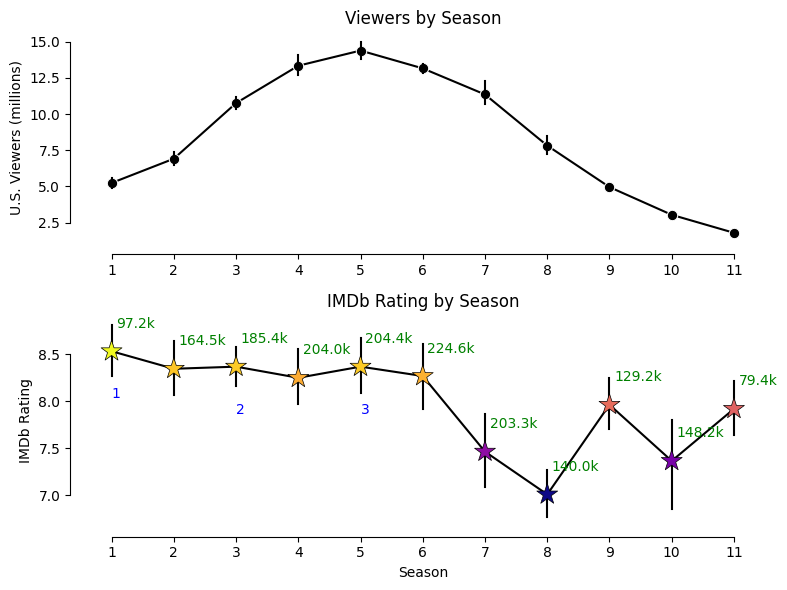

In [23]:
fig, ax = plt.subplots(2, figsize=(8,6), dpi=100)

sns.lineplot(
    x='season', y='U.S. viewers(millions)', data=df,  
    err_style='bars', marker='o', markersize=7.5, c='k',
    ax=ax[0],
)
sns.lineplot(
    x='season', y='rating', data=df,
    c='k',
    err_style='bars',
    ax=ax[1],
)

sns.scatterplot(
    x='season', y='rating', data=df.groupby('season')['rating'].mean().reset_index(),
    marker='*',s=250,
    hue='rating',
    palette='plasma',
    zorder=99, edgecolor='k',linewidth=0.5,
    ax=ax[1],
)
ax[1].get_legend().remove()

ax[0].set(
    xlabel=None, ylabel='U.S. Viewers (millions)', xticks=df['season'].unique(),
    title='Viewers by Season'
)
ax[1].set(
    xlabel='Season', ylabel='IMDb Rating', xticks=df['season'].unique(),
    title='IMDb Rating by Season'
)

for season in df['season'].unique():
    ax[1].text(
        x=season+0.075,
        y=df.loc[df['season']==season]['rating'].mean()+0.25,
        s=f"{df.loc[df['season']==season]['sample'].sum()/1000:.1f}k",
        c='green',
    )

top_3 = df.groupby('season')['rating'].mean().sort_values(ascending=False).iloc[:3]
for rank, (season, rating) in enumerate(top_3.to_dict().items()):
    ax[1].text(x=season, y=rating-0.5, s=rank+1, c='blue')



sns.despine(offset=7.5, trim=True)
plt.tight_layout()

plt.show()

Bottom plot shows the mean IMDb rating across all episodes within each season, along with the sample size for those ratings (green text).

In [24]:
top_3

season
1    8.533333
3    8.368750
5    8.368750
Name: rating, dtype: float64

According to the number of viewers, season 5 was the most watched. But the number of viewers doesn't indicate how good people thought the season was. The highest ranked seasons were Season 1 (8.53), Season 3 (8.37), and Season 5 (8.37).

## Which were the top 5 episodes of The Walking Dead?

In [25]:
grouped = df.groupby(['No. inseason', 'season'])

In [26]:
# To plot a heatmap we need to transform the data to a matrix of values
viewers_square = grouped['U.S. viewers(millions)'].median().unstack().T.sort_index(ascending=False)
ratings_square = grouped['rating'].mean().unstack().T.sort_index(ascending=False)

ratings_square # We need all of the NaN in there because not all seasons have the same #episodes

No. inseason,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
season,,,,,,,,,,,,,,,,,,,,,
11,8.4,8.5,7.8,7.3,7.7,8.7,7.8,8.3,8.7,7.5,...,7.5,7.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,7.4,6.9,7.5,7.1,8.0,7.7,7.7,7.1,7.4,8.0,...,7.4,8.3,7.1,6.1,7.3,5.1,4.0,9.1,NaN,NaN
9,7.3,7.7,7.7,8.0,9.2,7.8,7.1,8.8,7.8,7.8,...,9.2,7.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,6.9,6.7,6.3,6.8,7.2,6.1,6.5,6.7,6.8,7.6,...,7.7,7.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,9.1,7.1,7.5,7.6,6.8,5.7,7.9,8.7,8.0,7.3,...,7.5,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,8.6,9.2,9.2,8.2,7.2,7.6,8.0,8.0,9.6,8.3,...,7.9,6.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,9.6,8.5,9.0,7.4,7.9,8.0,7.9,8.7,7.9,7.5,...,8.5,9.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8.1,8.3,7.9,7.9,8.8,7.7,7.7,9.6,8.0,8.1,...,8.4,9.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8.8,8.5,8.1,9.3,8.1,8.1,8.5,8.9,8.0,8.6,...,8.8,8.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# To highlight the best episodes, we need to plot a rectangle over the cells in the matrix
# We need the row & column indexes to do this.
top_5 = grouped['rating'].max().sort_values(ascending=False).iloc[:5]
top_5

No. inseason  season
1             5         9.6
9             6         9.6
8             4         9.6
4             3         9.3
1             1         9.2
Name: rating, dtype: float64

In [28]:
# Coordinates will be from the top left of the matrix
coords = [(episode-1, max(df['season']) - season) for episode, season in top_5.index.tolist()]

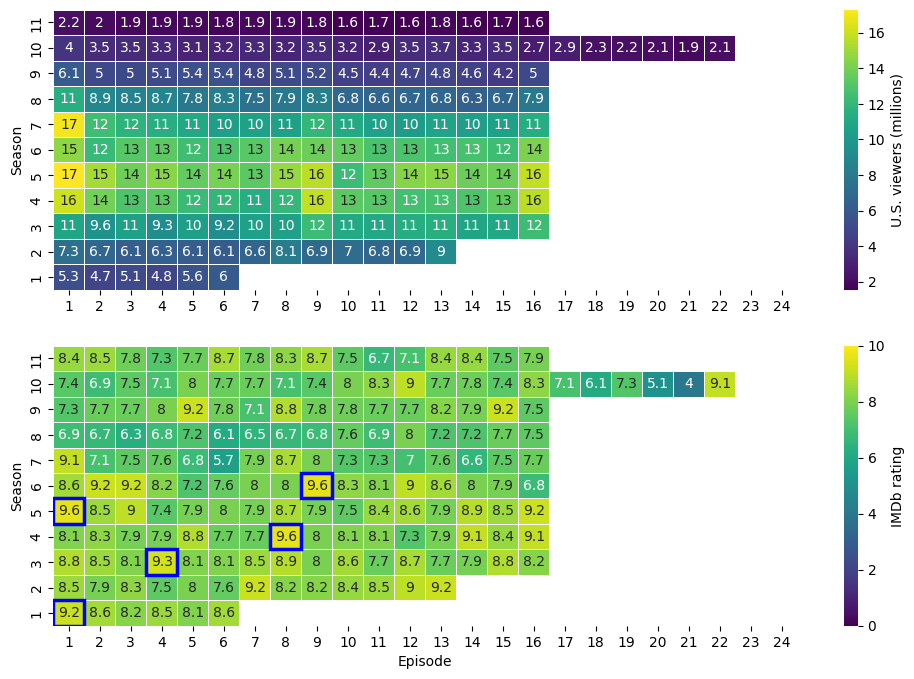

In [29]:
fig, ax=  plt.subplots(2, 1, figsize=(12,8), dpi=100)

sns.heatmap(
    data=viewers_square,
    cmap='viridis',
    cbar_kws={'label': 'U.S. viewers (millions)'},
    annot=True,
    ax=ax[0],
    linewidths=0.5
)

sns.heatmap(
    data=ratings_square,
    cmap='viridis',
    cbar_kws={'label': 'IMDb rating'},
    annot=True, 
    ax=ax[1],
    vmin=0, vmax=10,
    linewidths=0.5
)

# (episode_of_value, max(season)-season_of_value)
for coord in coords:
    ax[1].add_patch(Rectangle(coord, width=1, height=1, fill=False, edgecolor='b', lw=2.5))

ax[0].set(xlabel=None, ylabel='Season')
ax[1].set(xlabel='Episode', ylabel='Season')

plt.show()

In [30]:
df[['No.overall', 'No. inseason', 'season', 'episode', 'rating']].sort_values(by='rating', ascending=False).iloc[:5, :]

,No.overall,No. inseason,season,episode,rating
42,43,8,4,8,9.6
75,76,9,6,9,9.6
51,52,1,5,1,9.6
22,23,4,3,4,9.3
12,13,7,2,7,9.2


The top heatmap shows that most of the U.S. viewing volume was between seasons 3 & 7, echoing the line plot above.

From season 3 onwards, there were midseason breaks after episode 8. This creates a double first episode effect in each season (see the peaks on episode 1 and 9 forom seasons 3 through 8), and also creates a mid-season finale effect (view count peaks). 

S01E01, S05E01, S04E8, and S06E09 all fall around these points, so S03E04 stands out in this respect. According to [the Wikipedia page for this episode](https://en.wikipedia.org/wiki/Killer_Within), it is "often cited as one of the show's best episodes". Despite it being ranked 4th out of the top 5 here, there is a good argument for this episode being the best because it is not confounded by any "first/last episode" effects, unlike the other four.

## Who are the best writers for TWD?
Each writer will be associated with some number of episodes where each episode has a total view count and an IMDb rating, and the ratings for their episodes can be used to produce a writer score.

But first there needs to be more cleaning.

*Note that for the purpose of this pointless exercise I won't distinguish between how each writer contributed (story or teleplay).

In [31]:
# There are some duplicate names in the 'Written by' column because they might have contributed to multiple aspects (screenplay, story, etc).
# e.g. see index 3 with Charles H. Eglee.
df['Written by'].str.split('; ', expand=True)

,0,1,2,3,4
0,Frank Darabont,None,None,None,None
1,Frank Darabont,None,None,None,None
2,Charles H. Eglee,Jack LoGiudice,Charles H. Eglee,Jack LoGiudice,Frank Darabont
3,Robert Kirkman,None,None,None,None
4,Glen Mazzara,None,None,None,None
...,...,...,...,...,...
172,Erik Mountain,None,None,None,None
173,Jim Barnes,None,None,None,None
174,Nicole Mirante-Matthews,Magali Lozano,None,None,None
175,Magali Lozano,Erik Mountain,Kevin Deiboldt,None,None


In [32]:
# This can be corrected by applying a set on the string after splitting on the separator for the unique contributers.
df['Written by'] = df['Written by'].apply( lambda x: '; '.join(list(set(x.split('; ')))) )

In [33]:
# Now we only see a maximum of 3 contributors after duplicates removed
df['Written by'].str.split('; ', expand=True)

,0,1,2
0,Frank Darabont,None,None
1,Frank Darabont,None,None
2,Jack LoGiudice,Charles H. Eglee,Frank Darabont
3,Robert Kirkman,None,None
4,Glen Mazzara,None,None
...,...,...,...
172,Erik Mountain,None,None
173,Jim Barnes,None,None
174,Magali Lozano,Nicole Mirante-Matthews,None
175,Erik Mountain,Magali Lozano,Kevin Deiboldt


In [34]:
contributor_cols = [f'Contrib{i+1}' for i in range(df['Written by'].str.split('; ', expand=True).shape[-1])]

df[contributor_cols] = df['Written by'].str.split('; ', expand=True)

df

,No.overall,No. inseason,Title,Directed by,Written by,Original air date,U.S. viewers(millions),season,episode,airdate,rating,sample,Contrib1,Contrib2,Contrib3
0,1,1,Days Gone Bye,Frank Darabont,Frank Darabont,2010-10-31,5.35,1,1,11 May 2012,9.2,24863.0,Frank Darabont,None,None
1,2,2,Guts,Michelle MacLaren,Frank Darabont,2010-11-07,4.71,1,2,12 May 2012,8.6,15697.0,Frank Darabont,None,None
2,3,3,Tell It to the Frogs,Gwyneth Horder-Payton,Jack LoGiudice; Charles H. Eglee; Frank Darabont,2010-11-14,5.07,1,3,12 May 2012,8.2,14381.0,Jack LoGiudice,Charles H. Eglee,Frank Darabont
3,4,4,Vatos,Johan Renck,Robert Kirkman,2010-11-21,4.75,1,4,13 May 2012,8.5,14060.0,Robert Kirkman,None,None
4,5,5,Wildfire,Ernest Dickerson,Glen Mazzara,2010-11-28,5.56,1,5,13 May 2012,8.1,13504.0,Glen Mazzara,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,173,20,What's Been Lost,TBA,Erik Mountain,2022-10-23,NaN,11,20,2022,NaN,NaN,Erik Mountain,None,None
173,174,21,Outpost 22,TBA,Jim Barnes,2022-10-30,NaN,11,21,2022,NaN,NaN,Jim Barnes,None,None
174,175,22,TBA,TBA,Magali Lozano; Nicole Mirante-Matthews,2022-11-06,NaN,11,22,2022,NaN,NaN,Magali Lozano,Nicole Mirante-Matthews,None
175,176,23,TBA,TBA,Erik Mountain; Magali Lozano; Kevin Deiboldt,2022-11-13,NaN,11,23,2022,NaN,NaN,Erik Mountain,Magali Lozano,Kevin Deiboldt


In [35]:
# Melt the dataframe to have a single writer on each row, and keep the episode column intact
melted = df.melt(id_vars=['No.overall'], value_vars=contributor_cols, var_name='writer_key', value_name='writer')
melted

,No.overall,writer_key,writer
0,1,Contrib1,Frank Darabont
1,2,Contrib1,Frank Darabont
2,3,Contrib1,Jack LoGiudice
3,4,Contrib1,Robert Kirkman
4,5,Contrib1,Glen Mazzara
...,...,...,...
526,173,Contrib3,None
527,174,Contrib3,None
528,175,Contrib3,None
529,176,Contrib3,Kevin Deiboldt


In [36]:
# Expand the original dataframe so that there is a unique `writer` for each row by joining
long = df.merge(
    melted.loc[~melted['writer'].isna()],
    on='No.overall', how='outer'
)
long.head(7)

,No.overall,No. inseason,Title,Directed by,Written by,Original air date,U.S. viewers(millions),season,episode,airdate,rating,sample,Contrib1,Contrib2,Contrib3,writer_key,writer
0,1,1,Days Gone Bye,Frank Darabont,Frank Darabont,2010-10-31,5.35,1,1,11 May 2012,9.2,24863.0,Frank Darabont,None,None,Contrib1,Frank Darabont
1,2,2,Guts,Michelle MacLaren,Frank Darabont,2010-11-07,4.71,1,2,12 May 2012,8.6,15697.0,Frank Darabont,None,None,Contrib1,Frank Darabont
2,3,3,Tell It to the Frogs,Gwyneth Horder-Payton,Jack LoGiudice; Charles H. Eglee; Frank Darabont,2010-11-14,5.07,1,3,12 May 2012,8.2,14381.0,Jack LoGiudice,Charles H. Eglee,Frank Darabont,Contrib1,Jack LoGiudice
3,3,3,Tell It to the Frogs,Gwyneth Horder-Payton,Jack LoGiudice; Charles H. Eglee; Frank Darabont,2010-11-14,5.07,1,3,12 May 2012,8.2,14381.0,Jack LoGiudice,Charles H. Eglee,Frank Darabont,Contrib2,Charles H. Eglee
4,3,3,Tell It to the Frogs,Gwyneth Horder-Payton,Jack LoGiudice; Charles H. Eglee; Frank Darabont,2010-11-14,5.07,1,3,12 May 2012,8.2,14381.0,Jack LoGiudice,Charles H. Eglee,Frank Darabont,Contrib3,Frank Darabont
5,4,4,Vatos,Johan Renck,Robert Kirkman,2010-11-21,4.75,1,4,13 May 2012,8.5,14060.0,Robert Kirkman,None,None,Contrib1,Robert Kirkman
6,5,5,Wildfire,Ernest Dickerson,Glen Mazzara,2010-11-28,5.56,1,5,13 May 2012,8.1,13504.0,Glen Mazzara,None,None,Contrib1,Glen Mazzara


In [37]:
# Aggregate and sort by descending mean imdb rating
grp = long.groupby('writer')['rating'].describe().dropna()
grp.sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
writer,,,,,,,,
Seth Hoffman,10.0,8.730000,0.668414,7.9,8.175,8.70,9.200,9.6
Frank Darabont,4.0,8.650000,0.412311,8.2,8.500,8.60,8.750,9.2
Robert Kirkman,7.0,8.500000,0.458258,7.9,8.250,8.50,8.700,9.2
Glen Mazzara,8.0,8.437500,0.504090,7.9,8.050,8.30,8.850,9.2
Eli Jorné,3.0,8.433333,0.513160,8.0,8.150,8.30,8.650,9.0
Scott M. Gimple,23.0,8.313043,0.793900,6.8,7.800,8.30,9.100,9.6
Nichole Beattie,5.0,8.260000,0.364692,7.7,8.100,8.40,8.500,8.6
Evan Reilly,6.0,8.116667,0.495648,7.5,7.925,8.05,8.175,9.0
Jim Barnes,8.0,8.100000,0.459814,7.3,7.875,8.35,8.400,8.5


In [38]:
# Reasonable to exclude people who created very few episodes
grp = grp.loc[grp['count'] > 5]
grp.sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
writer,,,,,,,,
Seth Hoffman,10.0,8.730000,0.668414,7.9,8.175,8.70,9.200,9.6
Robert Kirkman,7.0,8.500000,0.458258,7.9,8.250,8.50,8.700,9.2
Glen Mazzara,8.0,8.437500,0.504090,7.9,8.050,8.30,8.850,9.2
Scott M. Gimple,23.0,8.313043,0.793900,6.8,7.800,8.30,9.100,9.6
Evan Reilly,6.0,8.116667,0.495648,7.5,7.925,8.05,8.175,9.0
Jim Barnes,8.0,8.100000,0.459814,7.3,7.875,8.35,8.400,8.5
Angela Kang,29.0,7.862069,0.760364,6.1,7.400,7.70,8.500,9.2
Channing Powell,18.0,7.772222,0.788748,6.3,7.325,7.85,8.100,9.2
Corey Reed,20.0,7.725000,0.664019,6.1,7.575,7.75,8.000,9.0


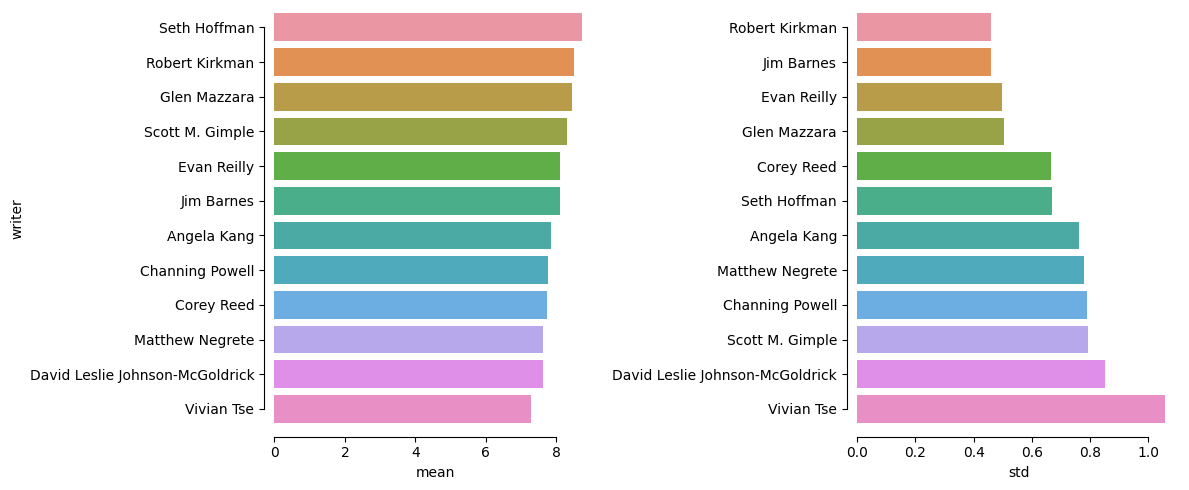

In [39]:
to_plot = grp.reset_index().sort_values(by='mean', ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=100)

sns.barplot(
    y='writer', x='mean', data=to_plot,
    # xerr=to_plot['std'],
    ax=ax[0]
)
sns.barplot(
    y='writer', x='std', data=to_plot.sort_values(by='std'),
    ax=ax[1]
)
ax[1].set(ylabel=None)
sns.despine(offset=7.5, trim=True)
plt.tight_layout()
plt.show()

The two barplots show the mean and SD for each writer's set of episodes. But when considering how good they are, we not only care about the highest overall rating (e.g. Seth Hoffman), but also the variability in ratings. A writer could have a very high mean rating, but if they also have high between-episode variability (i.e. SD) then it means the reception is mixed overall. Although Seth Hoffman has the highest mean rating, he also has quite relatively mixed ratings between episodes compared with Robert Kirkman.

To determine who the best writer is, the final ranking should account for both the mean and the standard deviation. This is because writers with a higher standard deviation produced episodes that were more mixed in their reception. Since we are primarily interested in obtaining an overall rank, we can rank order the mean and SD values to create two sets of rankings, and then aggregate these. There are many different rank aggregation techniques, but the simple option is to use the (arithmetic or geometric) mean of the two.

Alternatively, by making use of percentile ranks, we can simply scale the ranking of the mean by that of the SD (referred to as `'basic_score'` below). For example, if a writer has a high mean rating with a percentile of $0.9$ *and* a high $s$ for their ratings, with a percentile of 0.8, then their high mean rating percentile gets punished: $0.9 \cdot (1-0.8) = 0.18$. Conversely, if that writer had a low $s$ percentile of $0.25$, then their percentile rating gets punished far less: $0.9 \cdot (1-0.25) = 0.675$.

In [40]:
to_plot['mean_rank'] = to_plot['mean'].rank(pct=True) # percentile rank of means

to_plot['std_rank'] = 1 - to_plot['std'].rank(pct=True) # percentile rank of standard devs in descending order

to_plot['basic_score'] = to_plot['mean_rank'] * to_plot['std_rank']
to_plot['ARITH'] = to_plot[['mean_rank', 'std_rank']].mean(axis=1) # Arithmetic mean
to_plot['GEO'] = (to_plot['mean_rank'] * to_plot['std_rank']) ** (1/len(to_plot.index)) # Geometric mean (alternative approach)

to_plot.sort_values(by='ARITH', ascending=False)

,writer,count,mean,std,min,25%,50%,75%,max,mean_rank,std_rank,basic_score,ARITH,GEO
8,Robert Kirkman,7.0,8.500000,0.458258,7.9,8.250,8.50,8.700,9.2,0.916667,0.916667,0.840278,0.916667,0.985603
10,Seth Hoffman,10.0,8.730000,0.668414,7.9,8.175,8.70,9.200,9.6,1.000000,0.500000,0.500000,0.750000,0.943874
5,Glen Mazzara,8.0,8.437500,0.504090,7.9,8.050,8.30,8.850,9.2,0.833333,0.666667,0.555556,0.750000,0.952198
6,Jim Barnes,8.0,8.100000,0.459814,7.3,7.875,8.35,8.400,8.5,0.583333,0.833333,0.486111,0.708333,0.941661
4,Evan Reilly,6.0,8.116667,0.495648,7.5,7.925,8.05,8.175,9.0,0.666667,0.750000,0.500000,0.708333,0.943874
9,Scott M. Gimple,23.0,8.313043,0.793900,6.8,7.800,8.30,9.100,9.6,0.750000,0.166667,0.125000,0.458333,0.840896
0,Angela Kang,29.0,7.862069,0.760364,6.1,7.400,7.70,8.500,9.2,0.500000,0.416667,0.208333,0.458333,0.877465
2,Corey Reed,20.0,7.725000,0.664019,6.1,7.575,7.75,8.000,9.0,0.333333,0.583333,0.194444,0.458333,0.872435
1,Channing Powell,18.0,7.772222,0.788748,6.3,7.325,7.85,8.100,9.2,0.416667,0.250000,0.104167,0.333333,0.828217
7,Matthew Negrete,23.0,7.639130,0.778541,6.3,7.050,7.70,8.050,9.2,0.250000,0.333333,0.083333,0.291667,0.812958


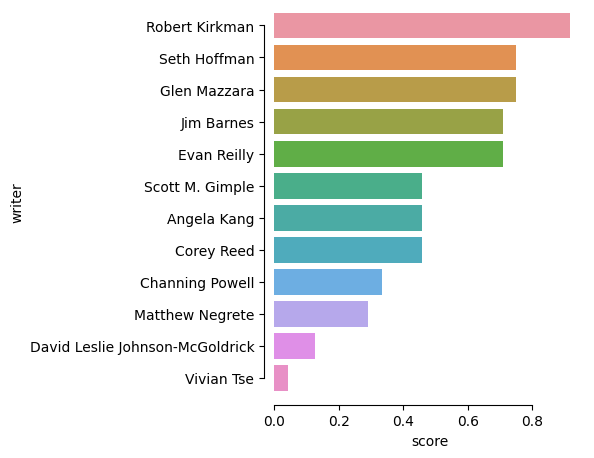

In [41]:
fig, ax = plt.subplots(figsize=(4,5), dpi=100)

# sns.barplot(x='basic_score', y='writer', data=to_plot.sort_values(by='basic_score', ascending=False), ax=ax)
sns.barplot(x='ARITH', y='writer', data=to_plot.sort_values(by='ARITH', ascending=False), ax=ax)
# sns.barplot(x='GEO', y='writer', data=to_plot.sort_values(by='GEO', ascending=False), ax=ax)

ax.set(xlabel='score')
sns.despine(offset=7.5, trim=True)

plt.show()

Accounting for the variability, the episodes created by Robert Kirkman are rated far higher than all others. Seth Hoffman & Glen Mazzara tie for second place, and Jim Barnes & Evan Reilly tie for third place. Despite being the top four in terms of episodes created (all > 20), Angela Kang, Matthew Negrete, Scott Gimple, and Corey Reed fail to make the top three in terms of overall episode reception, performing noticeably worse. (Using the `basic_score` eliminated the ties but gave a very similar result).

## Conclusion
The goal of this was to learn a little about how The Walking Dead was received by its viewers. 

The highest ranked seasons were seasons 1, 3, and 5, with Season 5 having the highest viewer count overall. 

The top 5 episodes were #1, #23, #43, #52, and #76, with #23 standing out as it was unlikely to be confounded by "first/last episode" effects, unlike the other four. According to Wikipedia, episode #23 could be the best of all 177.

The top 5 writers from the series, with the highest writer score, were Robert Kirkman, Seth Hoffman, Glen Mazzara, Jim Barnes, and Evan Reilly. None of the 5 writers with the highest episode counts were in the top 5 scoring writers, but Scott Gimple was ranked #4 if between-episode variability is not considered. Interestingly, Sang Kyu Kim - the writer of episode #23 - did not write any other episode of The Walking Dead, so they were not included in the best writer analysis due to having only a single episode.

As the initial creator of the original comic book series (along with Tony Moore), it seems fair that Robert Kirkman's episodes scored the highest.